# Task-Space Control of a 6 dof manipulator

## Imort all the modules needed for the simulation

In [1]:
from pickle import GLOBAL
import pinocchio as pin
import numpy as np
import sys
import os
from os.path import dirname, join, abspath
from pinocchio.visualize import MeshcatVisualizer
import time
import math
import meshcat
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation
import meshcat.transformations as tf
import meshcat.geometry as g
from numpy.linalg import inv,pinv,eig,norm,svd,det
plt.rcParams['text.usetex'] = True

## Bring the URDF model of the robot 

In [6]:
pinocchio_model_dir = '/home/unknown/Documents/PostDoc/ModelsCads/urdf' 
mesh_dir = '/home/unknown/Documents/PostDoc/ModelsCads/urdf/kinova_description/meshes' 
urdf_model_path =pinocchio_model_dir + '/SC_1roue.urdf'
model = pin.buildModelFromUrdf(urdf_model_path,pin.JointModelFreeFlyer())
data     = model.createData()
gravity_ = pin.Motion.Zero()
model.gravity  = gravity_
frameIndex = model.getFrameId('RW1')

In [7]:
import math as m
pin.forwardKinematics(model,data,np.array([0,0,0,0,0,0,0,0]))
pin.updateFramePlacements(model,data)
OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base
#OM_act.rotation
#OM_act.translation

In [8]:
def mprint(M, name="ans",eps=1e-15):
    '''
    Matlab-style pretty matrix print.
    '''
    if isinstance(M, pin.SE3):
        M = M.homogeneous
    if len(M.shape) == 1:
        M = np.expand_dims(M, axis=0)
    ncol = M.shape[1]
    NC = 6
    print(name, " = ")
    print()

    Mmin = lambda M: M.min()
    Mmax = lambda M: M.max()
    Mm = Mmin(abs(M[np.nonzero(M)]))
    MM = Mmax(abs(M[np.nonzero(M)]))

    fmt = "% 10.4f" if Mm < 1e-5 or MM > 1e6 or MM / Mm > 1e3 else "% 1.5f"
    for i in range(math.floor((ncol - 1) / NC + 1)):
        cmin = i * 6
        cmax = (i + 1) * 6
        cmax = ncol if ncol < cmax else cmax
        print("Columns %s through %s" % (cmin, cmax - 1))
        print()
        for r in range(M.shape[0]):
            sys.stdout.write("  ")
            for c in range(cmin, cmax):
                if abs(M[r,c])>eps: sys.stdout.write(fmt % M[r,c]  + "   ")
                else: sys.stdout.write(" 0"+" "*9)
            print()
        print()

In [9]:
#     M = pin.crba(model,data,q)
#     C= pin.computeCoriolisMatrix(model,data,q,qdot)
#     mprint(M, "M")
#     mprint(C, "C")
q = pin.neutral(model)
qdd = np.array([0,0,0,0,0,0,0])

qd = np.array([1,1,1,1,1,1,1])
pin.computeAllTerms(model, data, q, qd)
print(pin.rnea(model, data, q, qd, qdd))

C = pin.computeCoriolisMatrix(model,data,q,qd) 
mprint(C)

[  0.      0.      0.     19.935 -19.935   0.      0.   ]
ans  = 

Columns 0 through 5

   0         -112.00000    112.00000    0          0          0         
   112.00000    0         -112.00000    0          0          0         
  -112.00000    112.00000    0          0          0          0         
   0          0          0          0          5.28500    9.65000   
   0          0          0         -5.28500    0         -9.65000   
   0          0          0         -9.65000    9.65000    0         
   0          0          0         -5.00000    5.00000    0         

Columns 6 through 6

   0         
   0         
   0         
   5.00000   
  -5.00000   
   0         
   0         



In [18]:
#aMb = pin.SE3.Random()
#anu = pin.Motion.Random()
#bnu = aMb.act(anu)
#print(aMb)
#aXb = aMb.action
#bnu_vec = aXb @ anu.vector
#print(aXb)
#assert norm(bnu_vec-bnu.vector) < 1e-6

#frameI = pin.SE3(OM_act.rotation,np.array([0, 0, 0]))# 
#aXb = frameI.action

## Simulation function

In [19]:
def run_robot():

    # Sample a random configuration 
    q = pin.neutral(model)#np.array([0,0,0,0,0,0,0,0])
    qdot= np.array([1,1,1,1,1,1,1])
    t = 0
    dt = 0.005
    T = 5
    N = math.floor(T/dt)
    
    # for graphs
    t_list = []
    u_list = []    
    q_list = [] #q
    qdot_list = [] #qdot
    qbdot_list = []
    pose_des_list = []
    

    pin.forwardKinematics(model,data,q)
    pin.updateFramePlacements(model,data)
    OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base
        
    for k in range(N):
        t += dt
        tic = time.time()

        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base
        
        tau=np.array([0,0,0,0,0,0,1])

        # Compute forward dynamics
        qddot = pin.aba(model, data, q, qdot, tau) # [linear_acceleration_in_body_frame, angular_acceleration_in_body_frame, joint_accelerations]
        qdot = qdot + qddot*dt # body frame
        q = pin.integrate(model,q,qdot*dt) # the position of the basis center in the world frame 
        # and the orientation of the basis in the world frame stored as a quaternion
                
        # Show model with a visualizer of your choice
        q_list.append(q)
        t_list.append(t)
        u_list.append(tau)
        qdot_list.append(qdot)
        qbdot_list.append(qddot)
        pose_des_list.append(OM_act.translation)

        toc = time.time() 
        ellapsed = toc - tic
        dt_sleep = max(0,dt - (ellapsed))
        time.sleep(dt_sleep)

    t_list = np.array(t_list)
    u_list = np.array(u_list)
    q_list = np.array(q_list)
    qdot_list = np.array(qdot_list)
    qbdot_list =  np.array(qbdot_list)
    pose_des_list = np.array(pose_des_list)
    

    return t_list, u_list, q_list, qdot_list, qbdot_list, pose_des_list




## Graphs functions ($\tau$, $q$, ($\xi_{ee},\eta_{ee})$)

In [16]:

def graphs_quat(t_list, q_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, q_list[:, :4])
    plt.grid(True)
    ax.set_ylabel("q \ [rad]", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel('Time (s)')
    ax.legend((r"$q_1$",r"$q_2$",r"$q_3$",r"$q_4$"),loc="upper right")
    fig.tight_layout()
    plt.show()
    
def graphs_qs(t_list, q_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, q_list[:,7])
    plt.grid(True)
    ax.set_ylabel("q \ [rad]", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel('Time (s)')
    #ax.legend((r"$q_1$"),loc="upper right")
    fig.tight_layout()
    plt.show()

def graphs_qss(t_list, q_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, q_list[:, 4:7])
    plt.grid(True)
    ax.set_ylabel("q \ [rad]", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel('Time (s)')
    ax.legend((r"$q_1$",r"$q_2$",r"$q_3$"),loc="upper right")
    fig.tight_layout()
    plt.show()
    
def graphs_qdot(t_list, qdot_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, qdot_list[:, :3])
    ax.set_xlabel('Time (s)')
    ax.legend((r"$\dot{q}_1$",r"$\dot{q}_2$",r"$\dot{q}_3$",r"$\dot{q}_4$",r"$\dot{q}_5$",r"$\dot{q}_6$"),loc="upper right")
    plt.grid(True)
    ax.set_xlim(0, max(t_list))
    fig.tight_layout()
    plt.show()    

def graphs_qbdot(t_list, qbdot_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, qbdot_list[:, :])
    plt.grid(True)
    ax.set_xlim(0, max(t_list))
    fig.tight_layout()
    plt.show()  
    
def graphs_pose(t_list, pose):
    fig, ax = plt.subplots()
    plt.plot(t_list, pose[:,2])
    plt.grid(True)
    ax.set_xlim(0, max(t_list))
    fig.tight_layout()
    plt.show()      

In [17]:
t_list, u_list, q_list, qdot_list, qbdot_list, pose  = run_robot()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 6)

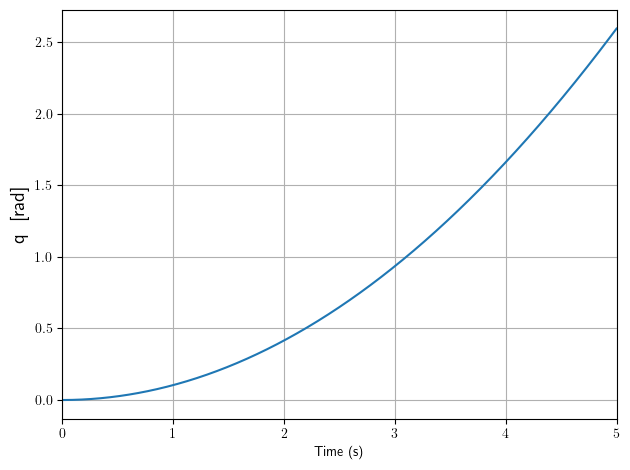

In [214]:
graphs_qs(t_list, q_list)

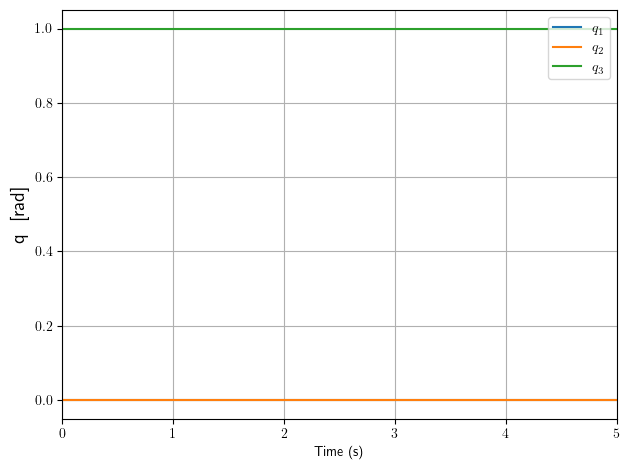

In [175]:
graphs_qss(t_list, q_list)

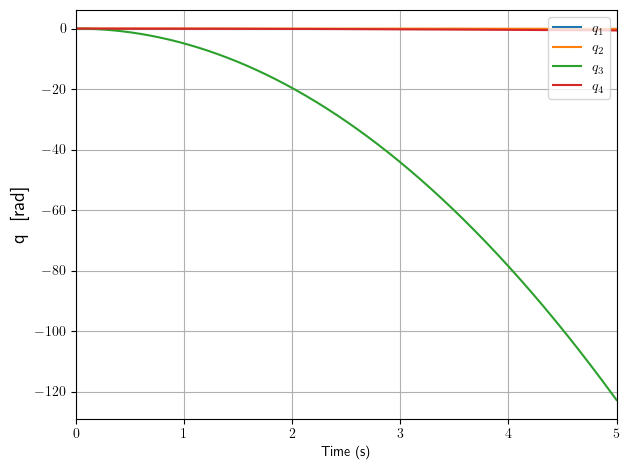

In [158]:
graphs_quat(t_list, q_list)

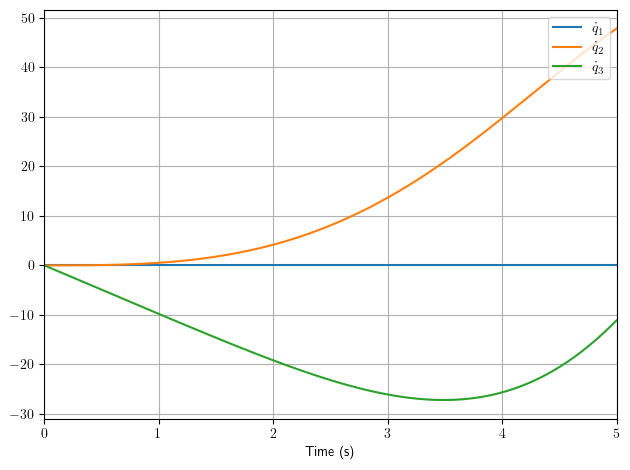

In [166]:
graphs_qdot(t_list, qdot_list)

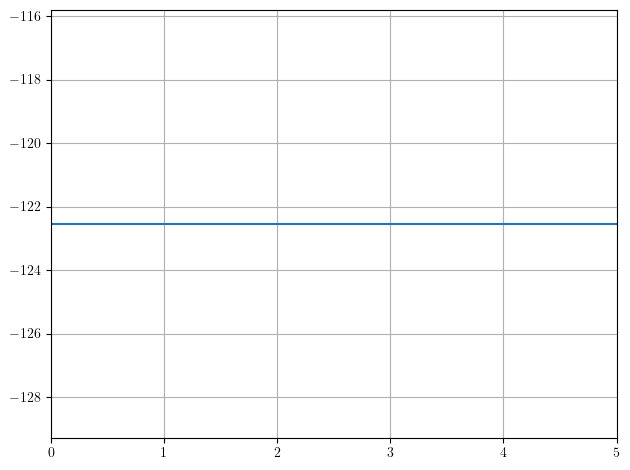

In [216]:
graphs_pose(t_list,pose)

In [ ]:
np